<a href="https://colab.research.google.com/github/okkuun/blog/blob/main/Check_seasonality_SSM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%%bash
pip install --upgrade statsmodels

  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [12]:
import numpy as np
import pandas as pd

import statsmodels as sm
from statsmodels.tsa.statespace.structural import UnobservedComponents
from statsmodels.datasets import elec_equip
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Loading and observing data

In [124]:
df = sns.load_dataset('flights')
df.head()

,year,month,passengers
0,1949,Jan,112
1,1949,Feb,118
2,1949,Mar,132
3,1949,Apr,129
4,1949,May,121


In [127]:
df.index = pd.date_range(start='1949-01-01', freq='MS', periods=len(df))
df.isnull().sum()

year          0
month         0
passengers    0
dtype: int64

In [128]:
df.head()

,year,month,passengers
1949-01-01,1949,Jan,112
1949-02-01,1949,Feb,118
1949-03-01,1949,Mar,132
1949-04-01,1949,Apr,129
1949-05-01,1949,May,121


In [129]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Freq: MS
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   year        144 non-null    int64   
 1   month       144 non-null    category
 2   passengers  144 non-null    int64   
dtypes: category(1), int64(2)
memory usage: 3.9 KB


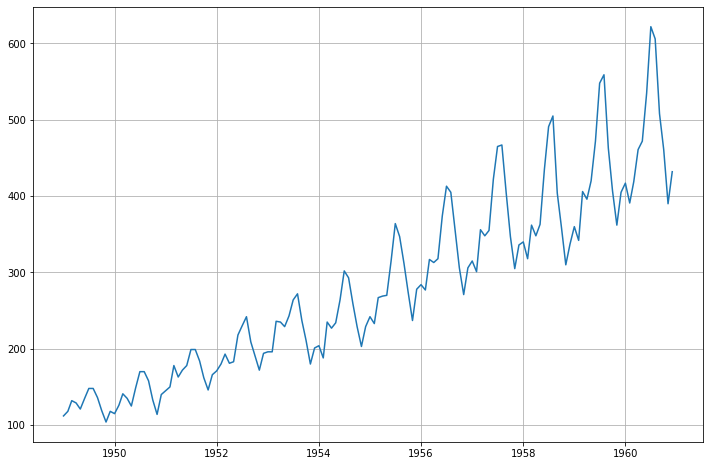

In [130]:
plt.figure(figsize=(12, 8))
plt.plot(df.index, df['passengers'])
plt.grid()
plt.show()

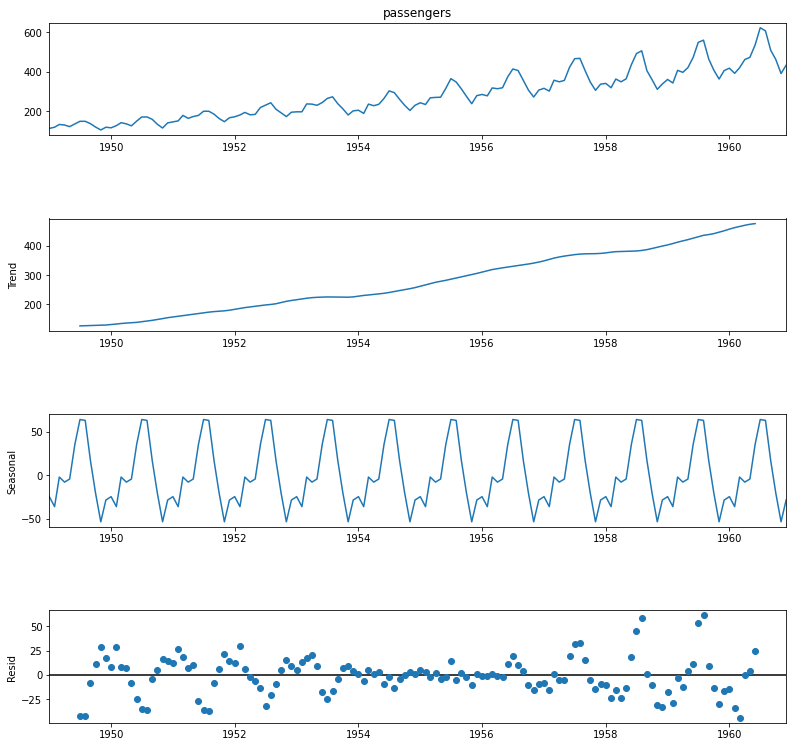

In [131]:
res = seasonal_decompose(df['passengers'])
fig = res.plot()
fig.set_size_inches(12, 12)
plt.show()

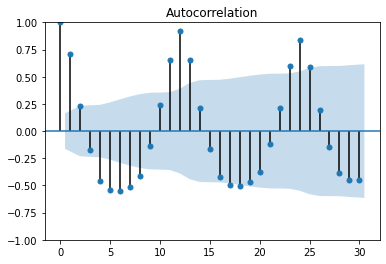

In [132]:
fig = plot_acf(res.seasonal, lags=30)
plt.show()

# Experiment

In [133]:
# test data
df["mode"] = df["year"].map(lambda x: "train" if x < 1960 else "test")
df.groupby("mode").agg(np.sum)["passengers"]

mode
test      5714
train    34649
Name: passengers, dtype: int64

In [134]:
df.tail()

,year,month,passengers,mode
1960-08-01,1960,Aug,606,test
1960-09-01,1960,Sep,508,test
1960-10-01,1960,Oct,461,test
1960-11-01,1960,Nov,390,test
1960-12-01,1960,Dec,432,test


In [191]:
# 1. seasonal
%%time
model_1 = UnobservedComponents(
    df.loc[df["mode"] == "train", "passengers"],
    level="local linear trend",
    seasonal=12
)
res_1 = model_1.fit()

CPU times: user 273 ms, sys: 650 µs, total: 274 ms
Wall time: 331 ms


In [192]:
print(res_1.summary())

# prediction
y_pred = res_1.predict(start='1949-01', end='1960-12')
df["pred_1"] = y_pred
mae_1 = np.mean(np.abs(df.loc[df["mode"]=="test", "passengers"] - df.loc[df["mode"]=="test", "pred_1"]))
print("MAE :", mae_1)

                            Unobserved Components Results                            
Dep. Variable:                    passengers   No. Observations:                  132
Model:                    local linear trend   Log Likelihood                -501.715
                   + stochastic seasonal(12)   AIC                           1011.430
Date:                       Sun, 27 Feb 2022   BIC                           1022.546
Time:                               07:39:05   HQIC                          1015.944
Sample:                           01-01-1949                                         
                                - 12-01-1959                                         
Covariance Type:                         opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular  4.639e-08     20.916   2.22e-09      1

In [185]:
# 2. Frequency-domain
%%time
model_2 = UnobservedComponents(
    df.loc[df["mode"] == "train", "passengers"],
    level="local linear trend",
    freq_seasonal=[{'period':12, 'harmonics':6}]
)
res_2 = model_2.fit()

CPU times: user 277 ms, sys: 0 ns, total: 277 ms
Wall time: 280 ms


In [186]:
print(res_2.summary())

# prediction
y_pred = res_2.predict(start='1949-01', end='1960-12')
df["pred_2"] = y_pred
mae_2 = np.mean(np.abs(df.loc[df["mode"]=="test", "passengers"] - df.loc[df["mode"]=="test", "pred_2"]))
print("MAE :", mae_2)

                                Unobserved Components Results                                
Dep. Variable:                            passengers   No. Observations:                  132
Model:                            local linear trend   Log Likelihood                -458.354
                   + stochastic freq_seasonal(12(6))   AIC                            924.707
Date:                               Sun, 27 Feb 2022   BIC                            935.790
Time:                                       07:31:00   HQIC                           929.207
Sample:                                   01-01-1949                                         
                                        - 12-01-1959                                         
Covariance Type:                                 opg                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------

In [177]:
# 3. Cycle
%%time
model_3 = UnobservedComponents(
    df.loc[df["mode"] == "train", "passengers"],
    level="local linear trend",
    cycle=True
)
res_3 = model_3.fit()

CPU times: user 114 ms, sys: 691 µs, total: 115 ms
Wall time: 116 ms


In [181]:
print(res_3.summary())

# prediction
y_pred = res_3.predict(start='1949-01', end='1960-12')
df["pred_3"] = y_pred
mae_3 = np.mean(np.abs(df.loc[df["mode"]=="test", "passengers"] - df.loc[df["mode"]=="test", "pred_3"]))
print("MAE :", mae_3)

                        Unobserved Components Results                         
Dep. Variable:             passengers   No. Observations:                  132
Model:             local linear trend   Log Likelihood                -629.951
                              + cycle   AIC                           1267.902
Date:                Sun, 27 Feb 2022   BIC                           1279.310
Time:                        07:29:31   HQIC                          1272.537
Sample:                    01-01-1949                                         
                         - 12-01-1959                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular   8.27e-06     96.626   8.56e-08      1.000    -189.384     189.384
sigma2.level      1013.6807    187

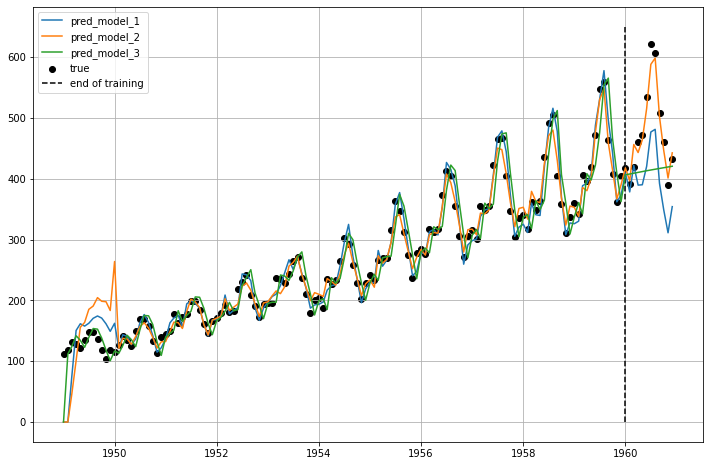

In [196]:
plt.figure(figsize=(12, 8))
plt.scatter(df.index, df["passengers"], label="true", color="black")
plt.plot(df.index, df["pred_1"], label="pred_model_1")
plt.plot(df.index, df["pred_2"], label="pred_model_2")
plt.plot(df.index, df["pred_3"], label="pred_model_3")
plt.vlines('1960-01', 0, 650, linestyle='--', label="end of training")
plt.legend()
plt.grid()
plt.show()

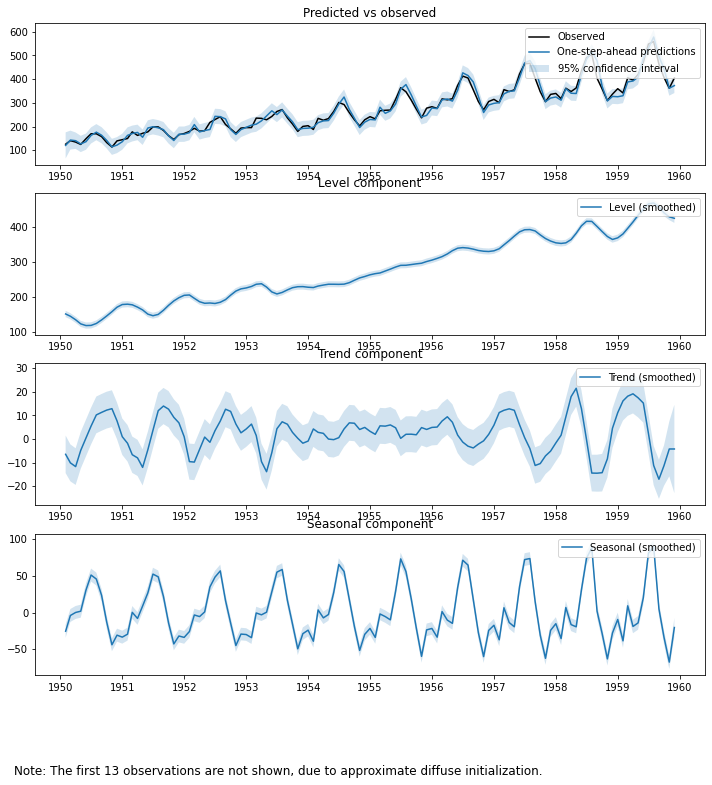

In [193]:
fig = res_1.plot_components()
fig.set_size_inches(12, 12)
plt.show()

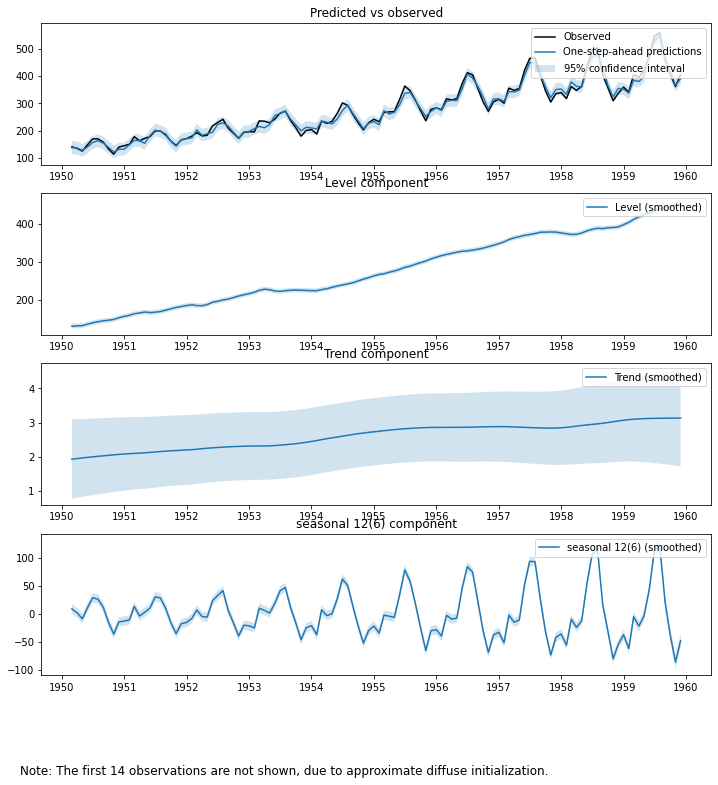

In [194]:
fig = res_2.plot_components()
fig.set_size_inches(12, 12)
plt.show()

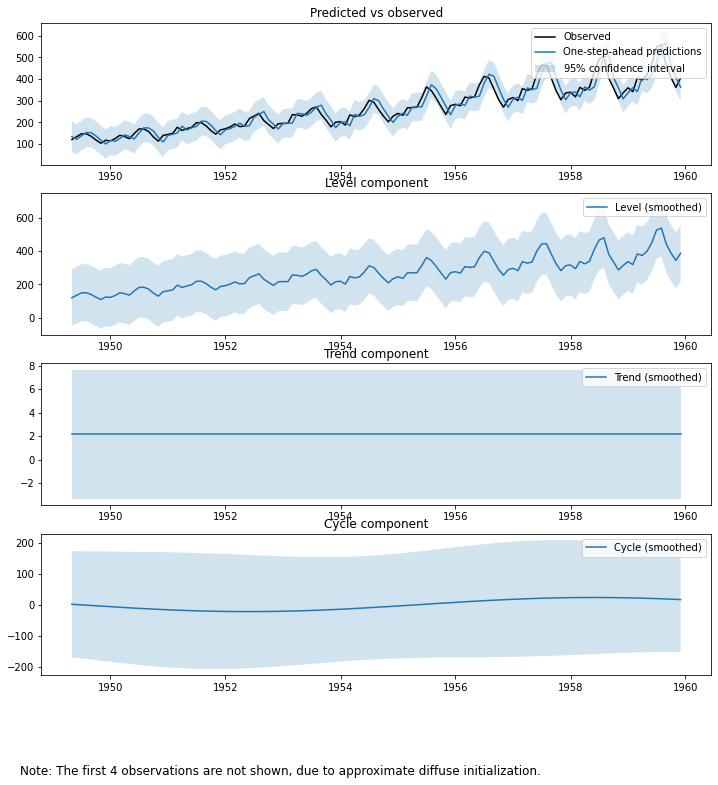

In [195]:
fig = res_3.plot_components()
fig.set_size_inches(12, 12)
plt.show()